<a href="https://colab.research.google.com/github/websitecreatr99/Classification_project/blob/main/KISHAN_PAHADIYA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INPORTING NECESSARY LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier



Loading the data using pandas


In [ ]:
# Load the dataset
data = pd.read_csv('/content/binary_classification_test.csv')

# Display the first few rows of the dataset
print(data.head())

   Feature_1  Feature_2 Feature_3  Target
0   0.713393  -2.575037         D       0
1   3.333164  -2.596342         C       0
2   1.711622  -2.422548         A       0
3   0.323768  -2.300698         D       0
4   1.222383  -2.455124         A       0


Checking the size of data

In [ ]:
data.shape

(2000, 4)

Checking the datatype and other properties by info() method

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  1913 non-null   float64
 1   Feature_2  1931 non-null   float64
 2   Feature_3  1945 non-null   object 
 3   Target     2000 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 62.6+ KB


Changing the datatype of Feature_3 column as it not an interger datatype

In [ ]:
data['Feature_3'] = data['Feature_3'].astype('str')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature_1  1913 non-null   float64
 1   Feature_2  1931 non-null   float64
 2   Feature_3  2000 non-null   object 
 3   Target     2000 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 62.6+ KB


Check for missinging values

In [ ]:
# Check for missing values
data.isnull().sum()

Feature_1    87
Feature_2    69
Feature_3     0
Target        0
dtype: int64

Checking for duplicate values

In [ ]:
data.duplicated().sum()

0

Checking outlier in numerical columns

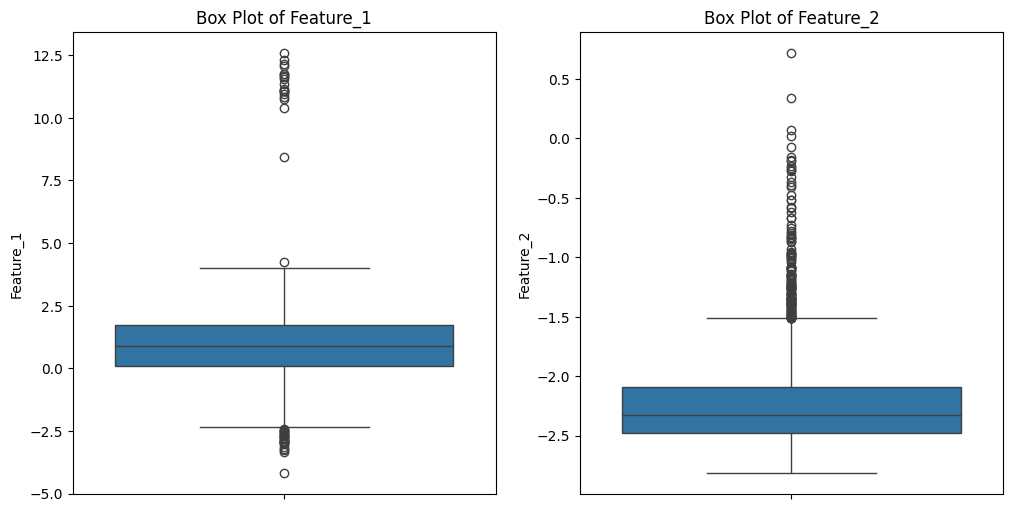

In [ ]:
# Plot box plots for Feature_1 and Feature_2
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=data['Feature_1'])
plt.title('Box Plot of Feature_1')

plt.subplot(1, 2, 2)
sns.boxplot(y=data['Feature_2'])
plt.title('Box Plot of Feature_2')

plt.show()

CONCLUSION : THERE ARE OUTLIERS IN THE DATAFRAME

Identify and Remove Outliers using IQR

In [ ]:

# Function to identify outliers using IQR
def remove_outliers_IQR(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

In [ ]:
# Remove outliers from Feature_1 and Feature_2
data_cleaned = remove_outliers_IQR(data, 'Feature_1')
data_cleaned = remove_outliers_IQR(data_cleaned, 'Feature_2')

In [ ]:
# Display the first few rows of the cleaned dataset
print(data_cleaned.head())
print(f"Original data shape: {data.shape}")
print(f"Cleaned data shape: {data_cleaned.shape}")


   Feature_1  Feature_2 Feature_3  Target
0   0.713393  -2.575037         D       0
1   3.333164  -2.596342         C       0
2   1.711622  -2.422548         A       0
3   0.323768  -2.300698         D       0
4   1.222383  -2.455124         A       0
Original data shape: (2000, 4)
Cleaned data shape: (1685, 4)


Checking for imbalanced dataset

In [ ]:
data_cleaned['Target'].value_counts()

Target
0    1607
1      78
Name: count, dtype: int64

CONCLUSION : DATA IS IMBALANCED

Preprocessing the Data using ColumnTransformer and Pipelines

In [ ]:
# Separate the features and target variable
X = data_cleaned.drop('Target', axis=1)
y = data_cleaned['Target']

In [ ]:
# Define the preprocessing for numerical features (imputation + scaling)
numerical_features = ['Feature_1', 'Feature_2']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [ ]:
# Define the preprocessing for categorical features (imputation + encoding)
categorical_features = ['Feature_3']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Combine preprocessing for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [ ]:
# Define the model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

Defining Hyperparameter Grids

In [ ]:
param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs']
    },
    'DecisionTreeClassifier': {
        'classifier__max_depth': [None, 10, 20],
        'classifier__min_samples_split': [2, 10],
        'classifier__min_samples_leaf': [1, 5]
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [None, 10],
        'classifier__min_samples_split': [2, 10],
        'classifier__min_samples_leaf': [1, 5],
        'classifier__class_weight': ['balanced']
    },
    'BaggingClassifier': {
        'classifier__n_estimators': [10, 50]
    },
    'AdaBoostClassifier': {
        'classifier__n_estimators': [50, 100],
        'classifier__learning_rate': [0.01, 1]
    },
    'GradientBoostingClassifier': {
        'classifier__n_estimators': [100, 300],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    }
}


What this funtion does :-

1.   Treating Imbalanced Dataset using SMOTE
2.   Defining a Function to Train and Evaluate Models with GridSearchCV
3.   using cross validation
4.   generating classification reports for each model
5.   ploting Confusion matrix, ROC, and feature importance for each model


In [ ]:
from sklearn.metrics import make_scorer, f1_score

def train_and_evaluate_model(model, param_grid, X_train, X_test, y_train, y_test):
    # Define the model pipeline with SMOTE
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),  # for treating imbanlanced dataset
        ('classifier', model)
    ])

    # Set up GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

    # Train the model with grid search
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_model = grid_search.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_test)

    # Print best parameters
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")

    # Classification report
    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    confusion_mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model.__class__.__name__}')
    plt.show()

    # ROC curve
    y_prob = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic: {model.__class__.__name__}')
    plt.legend(loc="lower right")
    plt.show()

    # Feature importances if available
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        feature_names = numerical_features + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features))
        importances = best_model.named_steps['classifier'].feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure()
        plt.title(f"Feature Importances: {model.__class__.__name__}")
        plt.bar(range(len(importances)), importances[indices], align="center")
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.xlim([-1, len(importances)])
        plt.show()

    # Return the best model and its F1-score
    f1 = f1_score(y_test, y_pred)
    return best_model, f1


Training and Evaluating Multiple Models




Best parameters for LogisticRegression: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       323
           1       0.25      0.86      0.39        14

    accuracy                           0.89       337
   macro avg       0.62      0.87      0.66       337
weighted avg       0.96      0.89      0.92       337



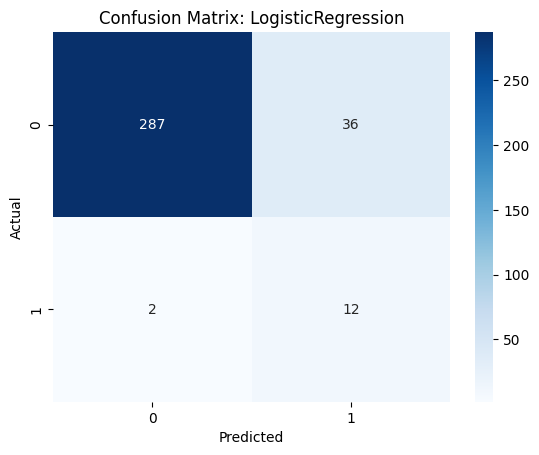

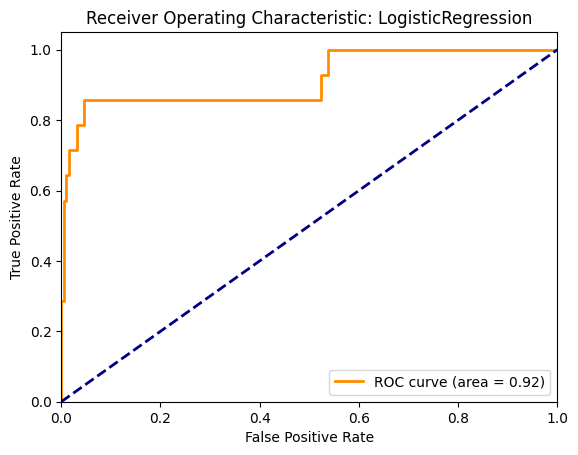

Best parameters for DecisionTreeClassifier: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Model: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       323
           1       0.27      0.86      0.41        14

    accuracy                           0.90       337
   macro avg       0.63      0.88      0.67       337
weighted avg       0.96      0.90      0.92       337



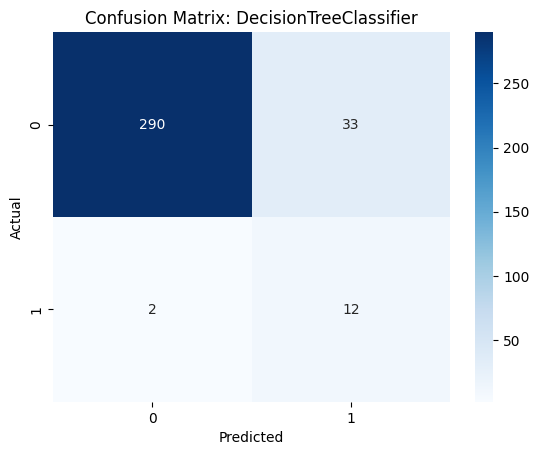

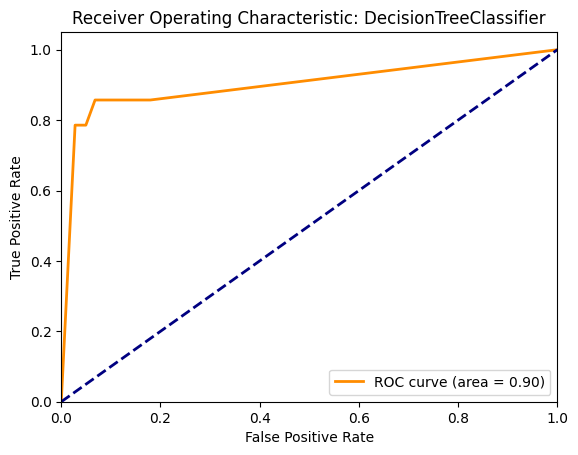

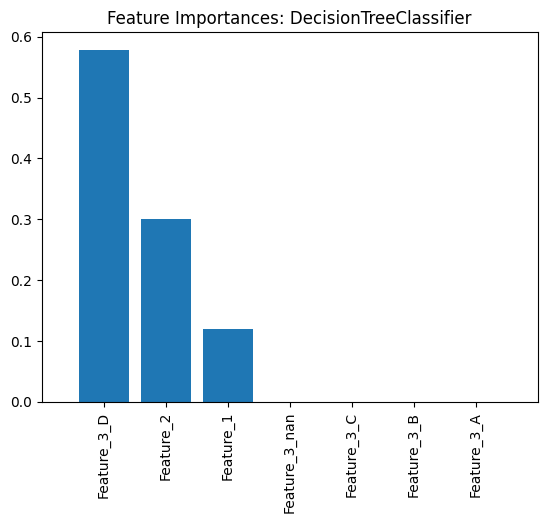

Best parameters for RandomForestClassifier: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       323
           1       0.27      0.86      0.41        14

    accuracy                           0.90       337
   macro avg       0.63      0.88      0.67       337
weighted avg       0.96      0.90      0.92       337



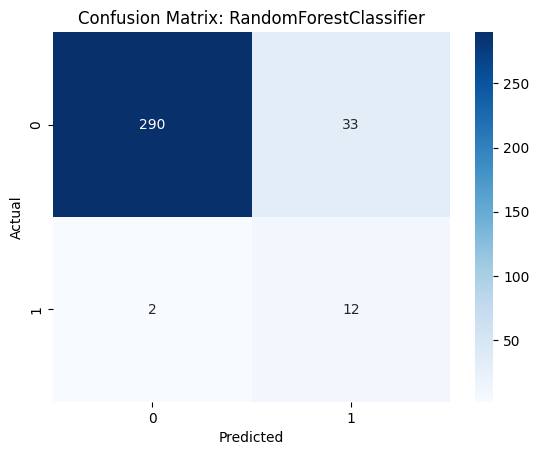

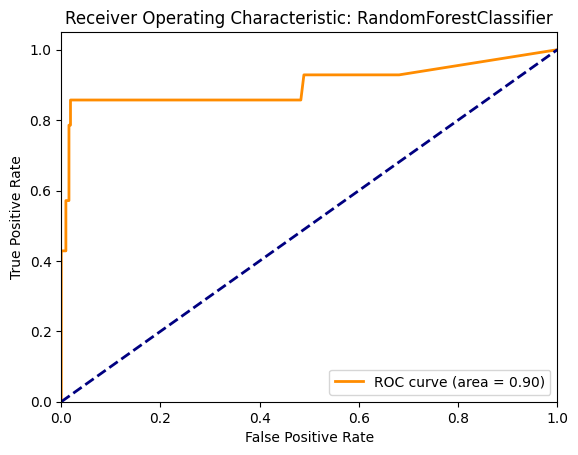

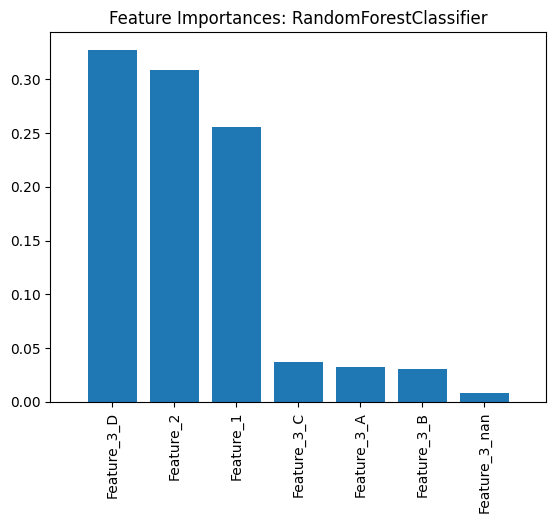

Best parameters for BaggingClassifier: {'classifier__n_estimators': 10}
Model: BaggingClassifier
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       323
           1       0.34      0.79      0.48        14

    accuracy                           0.93       337
   macro avg       0.67      0.86      0.72       337
weighted avg       0.96      0.93      0.94       337



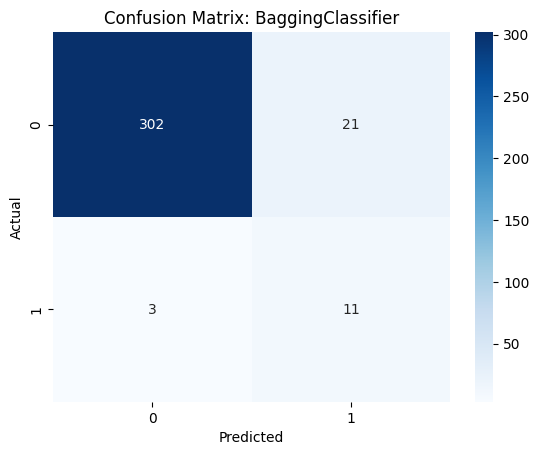

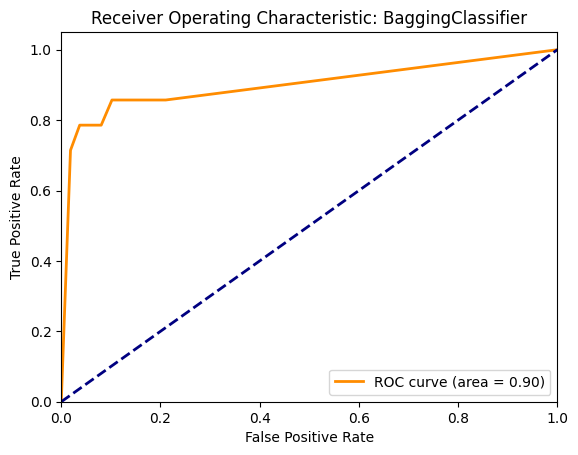

Best parameters for AdaBoostClassifier: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}
Model: AdaBoostClassifier
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       323
           1       0.26      0.86      0.40        14

    accuracy                           0.89       337
   macro avg       0.63      0.88      0.67       337
weighted avg       0.96      0.89      0.92       337



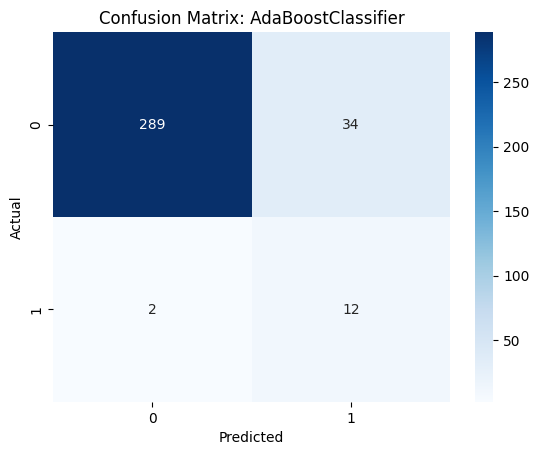

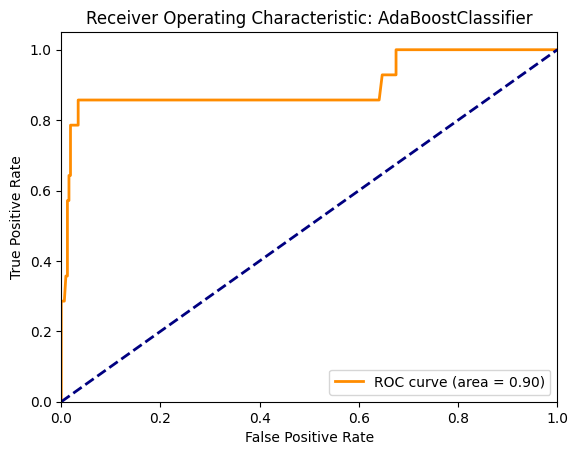

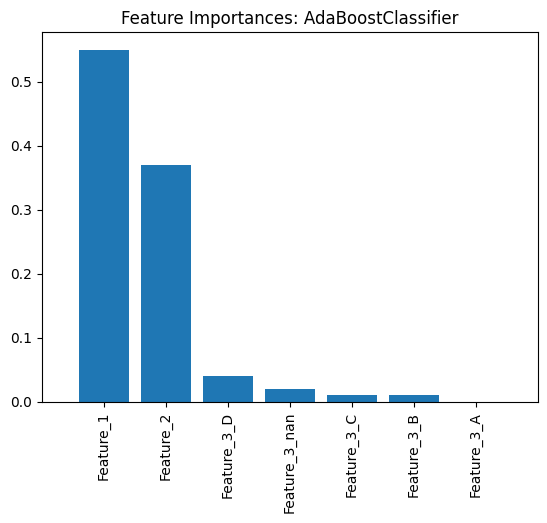

Best parameters for GradientBoostingClassifier: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Model: GradientBoostingClassifier
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       323
           1       0.26      0.79      0.39        14

    accuracy                           0.90       337
   macro avg       0.63      0.84      0.67       337
weighted avg       0.96      0.90      0.92       337



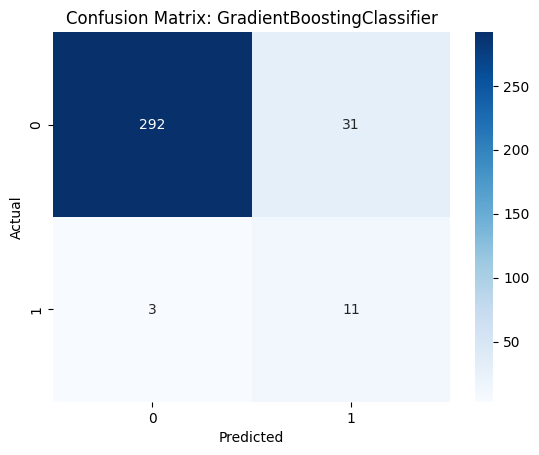

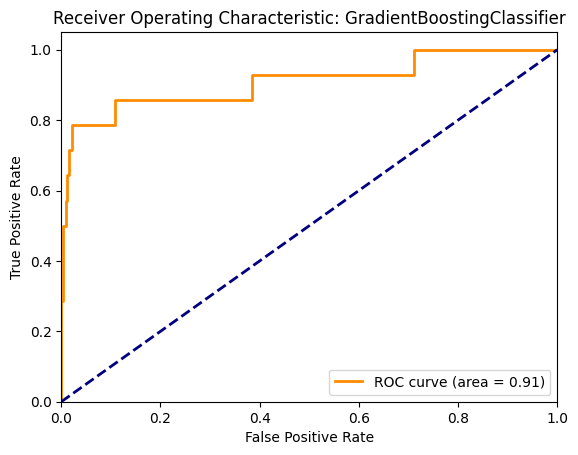

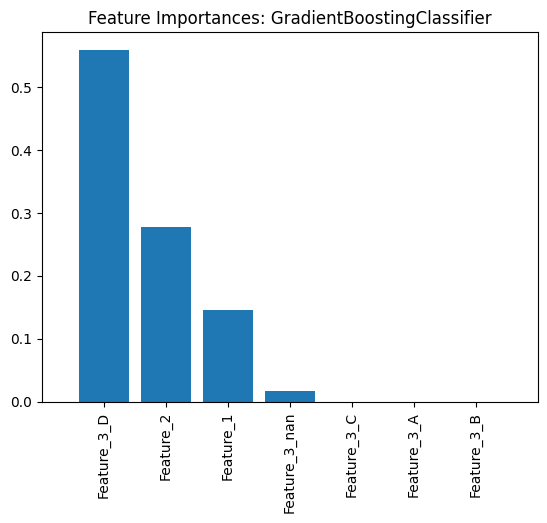

The best model is BaggingClassifier with an F1-score of 0.48


In [ ]:
# List of models to evaluate
models = [
    LogisticRegression(random_state=42),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    BaggingClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]

# Dictionary to store models and their F1-scores
model_performance = {}

# Train and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    best_model, f1 = train_and_evaluate_model(model, param_grids[model_name], X_train, X_test, y_train, y_test)
    model_performance[model_name] = (best_model, f1)

# Identify the best model based on F1-score
best_model_name = max(model_performance, key=lambda k: model_performance[k][1])
best_model, best_f1 = model_performance[best_model_name]

print(f"The best model is {best_model_name} with an F1-score of {best_f1:.2f}")


CONCLUSION :- AS THE DATA IS IMBALANCED SO THE IMPORTANT METRIC WOULD BE F1 SCORE TO FIND THE BEST MODEL SO THE BEST MODEL IS ---- BaggingClassifier with an F1-score of 0.48

# **THANK YOU**